# handLmakr
### autoregressive character-level language model for making cf usernames, made from scratch. similar to andrej karpathy's makemore

### some notable features:
- fetches data from cf api
- neural network model from scratch with custom defined layers
- this model is an MLP
- embedding layers to represent chars as vectors
- batch normalisation and Tanh activation funcns in hidden layers
- trained using SGD

In [18]:
import requests
url="https://codeforces.com/api/user.ratedList" # cf provided api
response=requests.get(url)
response_text=response.text

In [19]:
import json
data=json.loads(response_text)
handles=[u['handle'] for u in data['result'] if 'handle' in u]
handles[0:5]

['jiangly', 'Kevin114514', 'jqdai0815', 'orzdevinwang', 'tourist']

In [20]:
top_10000=handles[:10000] # number of handles to include
# currently im taking 10k
with open("handles.txt","w",encoding="utf-8") as f:
    for h in top_10000:
        f.write(h + "\n")
print("saved",len(top_10000),"handles to handles.txt")

saved 10000 handles to handles.txt


In [21]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [22]:
# read in all the words
words = open('handles.txt', 'r', encoding='utf-8').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])
# words[:8]

10000
24
['jiangly', 'Kevin114514', 'jqdai0815', 'orzdevinwang', 'tourist', 'ecnerwala', 'Benq', 'ksun48']


In [23]:
# build the vocabulary of characters and mappins to/from integers
# Define the set of characters allowed in Codeforces usernames
allowed_chars = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-_'
chars = sorted(list(set(allowed_chars))) # Use the defined set of allowed characters

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 # Add the special '.' character for padding and end-of-word
itos = {i:s for s,i in stoi.items()}
vocab_size=len(itos)
print(itos)
print(vocab_size)

{1: '-', 2: '0', 3: '1', 4: '2', 5: '3', 6: '4', 7: '5', 8: '6', 9: '7', 10: '8', 11: '9', 12: 'A', 13: 'B', 14: 'C', 15: 'D', 16: 'E', 17: 'F', 18: 'G', 19: 'H', 20: 'I', 21: 'J', 22: 'K', 23: 'L', 24: 'M', 25: 'N', 26: 'O', 27: 'P', 28: 'Q', 29: 'R', 30: 'S', 31: 'T', 32: 'U', 33: 'V', 34: 'W', 35: 'X', 36: 'Y', 37: 'Z', 38: '_', 39: 'a', 40: 'b', 41: 'c', 42: 'd', 43: 'e', 44: 'f', 45: 'g', 46: 'h', 47: 'i', 48: 'j', 49: 'k', 50: 'l', 51: 'm', 52: 'n', 53: 'o', 54: 'p', 55: 'q', 56: 'r', 57: 's', 58: 't', 59: 'u', 60: 'v', 61: 'w', 62: 'x', 63: 'y', 64: 'z', 0: '.'}
65


In [24]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [25]:
# build the dataset
block_size=8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X,Y=[], []
  for w in words:
    # print(w)
    context=[0]*block_size
    for ch in w+'.':
      ix=stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context=context[1:]+[ix] # crop and append
  X=torch.tensor(X)
  Y=torch.tensor(Y)
  print(X.shape, Y.shape)
  return X,Y

# import random
# random.seed(42)
# random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
# training split, dev/validation split, test split
# 80%, 10%, 10%

torch.Size([79269, 8]) torch.Size([79269])
torch.Size([9869, 8]) torch.Size([9869])
torch.Size([9822, 8]) torch.Size([9822])


In [26]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> r
.......r --> e
......re --> a
.....rea --> l
....real --> p
...realp --> s
..realps --> d
.realpsd --> o
realpsdo --> i
ealpsdoi --> n
alpsdoin --> g
lpsdoing --> d
psdoingd --> a
sdoingda --> m
doingdam --> y
oingdamy --> o
ingdamyo --> o
ngdamyoo --> .
........ --> l
.......l --> u


In [27]:
# Near copy paste of the layers developed in previous part

# basically just rebuilding torch.nn
# api is almost exactly same (fully same actually)

# ----------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 ## note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self,x):
    self.out=x@self.weight
    if self.bias is not None:
      self.out+=self.bias
    return self.out

  def parameters(self):
    return [self.weight]+([] if self.bias is None else [self.bias])

# ----------------------------------------------------------------
class BatchNorm1d:

  # slightly diff from pt.nn since:
    # pt expects input (N,C) or (N,C,L)
    # we expect  input (N,C) or (N,L,C)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps=eps
    self.momentum=momentum
    self.training=True
    # parameters(trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean=torch.zeros(dim)
    self.running_var=torch.ones(dim)

    # running mean and var trained outside of backprop
    # trained using exponential moving average

  def __call__(self,x):
    # calculate the forward pass
    if self.training:
      if x.ndim==2:
        dim = 0
      elif x.ndim==3:
        dim=(0,1)
      xmean=x.mean(dim, keepdim=True) # batch mean
      xvar=x.var(dim, keepdim=True) # batch variance
    else:
      xmean=self.running_mean
      xvar=self.running_var
    xhat=(x-xmean)/torch.sqrt(xvar+self.eps) # normalize to unit variance
    self.out=self.gamma*xhat+self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean=(1-self.momentum)*self.running_mean+self.momentum*xmean
        self.running_var=(1-self.momentum)*self.running_var+self.momentum*xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# ----------------------------------------------------------------
class Tanh:
  def __call__(self,x):
    self.out=torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# ----------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight=torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out=self.weight[IX] # assign output to self.out
    return self.out

  def parameters(self):
    return [self.weight]

# ----------------------------------------------------------------
class FlattenConsecutive: # name doesnt correlate to pt's Flatten() becaues funcn is different

  def __init__(self, n):
    self.n=n

  def __call__(self,x):
    B, T, C = x.shape
    x=x.view(B, T//self.n, C*self.n)
    if x.shape[1]==1:
      x=x.squeeze(1)
    self.out=x
    return self.out

  def parameters(self):
    return []

# ----------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers=layers

  def __call__(self, x):
    for layer in self.layers:
      x=layer(x)
    self.out=x
    return self.out

  def parameters(self):
    # get params of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [28]:
torch.manual_seed(42); # seed rng for reproducibility

# g = torch.Generator().manual_seed(2147483647) # for reproducibility
# ^^ this wont be needed

In [29]:
# original network
# MLP revisited
# n_embd=10 # the dimensionality of the character embedding vectors
# n_hidden = 200 # the number of neurons in the hiddne layer of the MLP
# model=Sequential([
#     Embedding(vocab_size, n_embd),
#     FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, vocab_size)
# ])

# hierarchial network
n_embd=24 # the dimensionality of the character embedding vectors
n_hidden=128 # the number of neurons in the hidden layer of the MLP
model=Sequential([
  Embedding(vocab_size,n_embd),
  FlattenConsecutive(2),Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden),Tanh(),
  FlattenConsecutive(2),Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden),Tanh(),
  FlattenConsecutive(2),Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden),Tanh(),
  Linear(n_hidden,vocab_size),
])

# param init
with torch.no_grad():
  model.layers[-1].weight*= 0.1 # last layer make less confident
  # weights scaled down so we are no confidenrtly wrong at init

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

82393


In [30]:
ix=torch.randint(0, Xtr.shape[0], (4,)) # lets look at a batch of just 4 exmaples
Xb, Yb = Xtr[ix], Ytr[ix]
logits= model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0, 46, 43, 51, 39, 52],
        [ 0,  0,  0,  0,  0, 12, 40, 42],
        [ 0,  0,  0,  0,  0,  0, 46, 53],
        [39, 52, 42, 56, 43, 63, 15, 39]])

In [31]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 65)


In [32]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 128])

In [33]:
logits.shape

torch.Size([4, 65])

now we have a nice 3 layer neural net<br>basically corresponds to [this](https://miro.medium.com/1*URv2n5wz-zIeb-7SXpOw2A.png) except we only have 3 layers instead of 4 like in the img<br>we have a total receptive field size of 8 chars (16 in img)

In [34]:
# same optimization as last time
max_steps=200000
batch_size=32
lossi=[]

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass

  # x=Xb
  # for layer in layers:
  #   x=layer(x)
  # ^^ we dont have to do this forwarding here,
  #    instead we can just call the model on the input data

  logits = model(Xb)
  loss=F.cross_entropy(logits, Yb) # loss funcn

  # backward pass
  for p in parameters:
    p.grad=None
  loss.backward()

  # update: simple SGD
  lr=0.1 if i<150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i%10000==0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break

      0/ 200000: 4.1850
  10000/ 200000: 3.5114
  20000/ 200000: 3.0082
  30000/ 200000: 2.5393
  40000/ 200000: 2.8131
  50000/ 200000: 2.8152
  60000/ 200000: 2.5227
  70000/ 200000: 2.1059
  80000/ 200000: 2.0177
  90000/ 200000: 2.5048
 100000/ 200000: 2.3455
 110000/ 200000: 2.0548
 120000/ 200000: 2.2921
 130000/ 200000: 2.1398
 140000/ 200000: 2.5170
 150000/ 200000: 2.5290
 160000/ 200000: 2.0648
 170000/ 200000: 2.1877
 180000/ 200000: 1.7531
 190000/ 200000: 1.9244


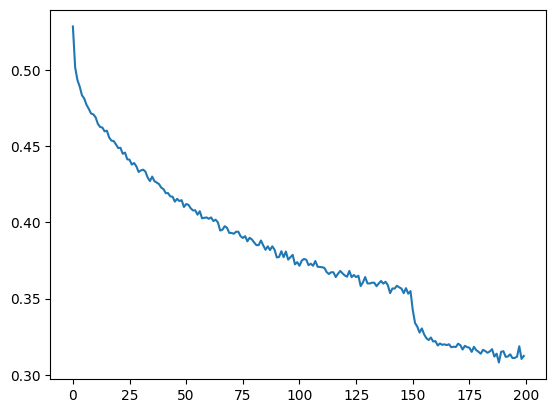

In [35]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [36]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training=False

In [37]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y={
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  logits=model(x)
  loss=F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9102489948272705
val 3.5626847743988037


terrible loss but fine for now

In [44]:
# sample from the model

for _ in range(20):
  out = []
  context = [0] * block_size # initialize with all ...
  while True:
    # forward pass the neural net
    logits=model(torch.tensor([context]))
    probs=F.softmax(logits, dim=1)
    # sample from the distribution
    ix= torch.multinomial(probs, num_samples=1).item()
    # shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break
  print(''.join(itos[i] for i in out[:-1])) # decode and print the generated word

1aibo
hat_onna4
jji9056
Ahmed_Forementourp
Leled-IB
armmalCks
joskyles
KaiyanSheew
Shrinhseictivu121
mj175
Sumbrohana
ammad_kabari_yh10
RUSM
dkovakau
jaroth
IngLightomon
Artemantiosama
ziehgu
slorkohaivana
random2005


ok nice. one full word at end
## thank you !